# Flare ribbons detection

### Diploma thesis
#### Author: Bc. Lívia Potočňáková

## 1. ENVIROMENT SETUP

In [ ]:
import sys
!pip install -r requirements.txt
sys.path.append('./src')

In [ ]:
pip install -e .

In [2]:
import glob
import zipfile
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
import numpy as np
import cv2
import pandas as pd
from mega import Mega

from skimage.morphology import skeletonize_3d
from scipy.ndimage import distance_transform_edt

In [9]:
from dsepruning import skel_pruning_DSE
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics, getSlope, intersects, getLength, minDistance, cleanLines

#### Set variables

In [13]:
# seed for image shuffle
SEED = 42

IMG_SIZE = 512     # resize imgs to 512x512
BATCH_SIZE = 20    # Set batch size
SEED = 42          # set seed for reproducibility
EPOCHS = 100       # Set number of epochs

In [14]:
MODEL_NAME = "model_eruptions_5k"
model_filename = f"./{MODEL_NAME}.h5"  

### Load prepared data 
* data preparation is in "data\_preparation.ipynb" file

#### Download data and trained model

In [ ]:
mega = Mega()
m = mega.login()
print("Downloading ...")
try:
    m.download_url('https://mega.nz/file/G3JzHQ4L#KDLGTYzP9qcYLYFbNQv33D-ZSJAJefFtLBHrwRSX_qo')
except PermissionError:
    pass
print("Model downloaded.")


In [7]:
# zipped data is approx 2GB large
try:
    m.download_url('https://mega.nz/file/7mQHlKAD#41n981usNI726F3LnvIwYNP0_wmUvCzspGfPHlFYJvY')
except PermissionError:
    pass

print("Data downloaded.")

Data downloaded.


In [12]:
# unzipped data have approx. 11GB 
print("Unzipping ...")
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")
print("DONE")

Unzipping ...
DONE


In [92]:
# load input images
x = []
with open('./data/imgs_filtered_5k.npy', 'rb') as f:
    x = np.load(f)

# load manual segmentation masks
masks = []
with open('./data/masks_filtered_5k.npy', 'rb') as f:
    masks = np.load(f)

# load image names
imgs_names = []
with open('./data/imgs_names_filtered_5k.npy', 'rb') as f:
    imgs_names = np.load(f)

## 2. PREPARE TRAIN, TEST AND VALIDATION SETS

In [15]:
# split all three arrays into train, test and val sets
x_t, x_test, y_t, y_test = train_test_split(x, masks, test_size=0.2, random_state=SEED)
x_names, x_test_names = train_test_split(imgs_names, test_size=0.2, random_state=SEED)

x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.1, random_state=SEED)
x_train_names, x_val_names = train_test_split(x_names, test_size=0.1, random_state=SEED)

In [16]:
# input shape should be (512, 512, 1)
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_val.shape}  Test shape: {x_test.shape}")

Input shape: (512, 512, 1)
Train shape: (3600, 512, 512, 1)  Val shape: (400, 512, 512, 1)  Test shape: (1000, 512, 512, 1)


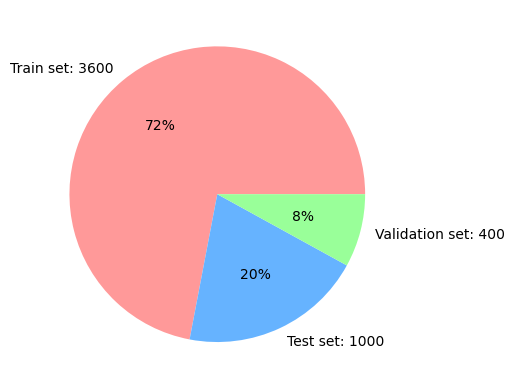

In [67]:
# display sets
data={'Train set: '+ str(len(x_train)) : len(x_train),'Test set: '+ str(len(x_test)): len(x_test),'Validation set: '+ str(len(x_val)): len(x_val)}
subject=list(data.keys())
marks=list(data.values())
colors = ['#ff9999','#66b3ff','#99ff99']
#creating pie plot
plt.pie(marks,labels=subject, autopct='%1.0f%%',colors=colors)
plt.show()

## 3. DEEP LEARNING APPROACH

### Training SCSS-net model

* The SCSS-net model architecture is defined in **./src/model_scss_net.py**. 

In [ ]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE        

# Set Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)

2023-04-02 21:36:04.098527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7414 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:8b:00.0, compute capability: 6.1


In [ ]:
# Train model
history = model.fit(
    x_train,
    y_train,
    steps_per_epoch=STEPS,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint],
    verbose=2)

# Plot training history (Metrics and Loss)
plot_metrics(history).show()

### Loading model's weights

* Load the trained model

In [13]:
input_shape = x[0].shape
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

2023-04-17 08:28:16.910587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7414 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:8b:00.0, compute capability: 6.1


In [14]:
model.load_weights("./"+model_filename)

### Create predictions on test set

In [96]:
# create predictions only if enough memory is available 
y_pred = model.predict(x_test)  

32/32 [==============================] - 6s 198ms/step


### Load pre-saved predictions on test set

In [34]:
# load saved predictions
y_pred = []
with open('./data/predictions.npy', 'rb') as f:
    y_pred = np.load(f)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

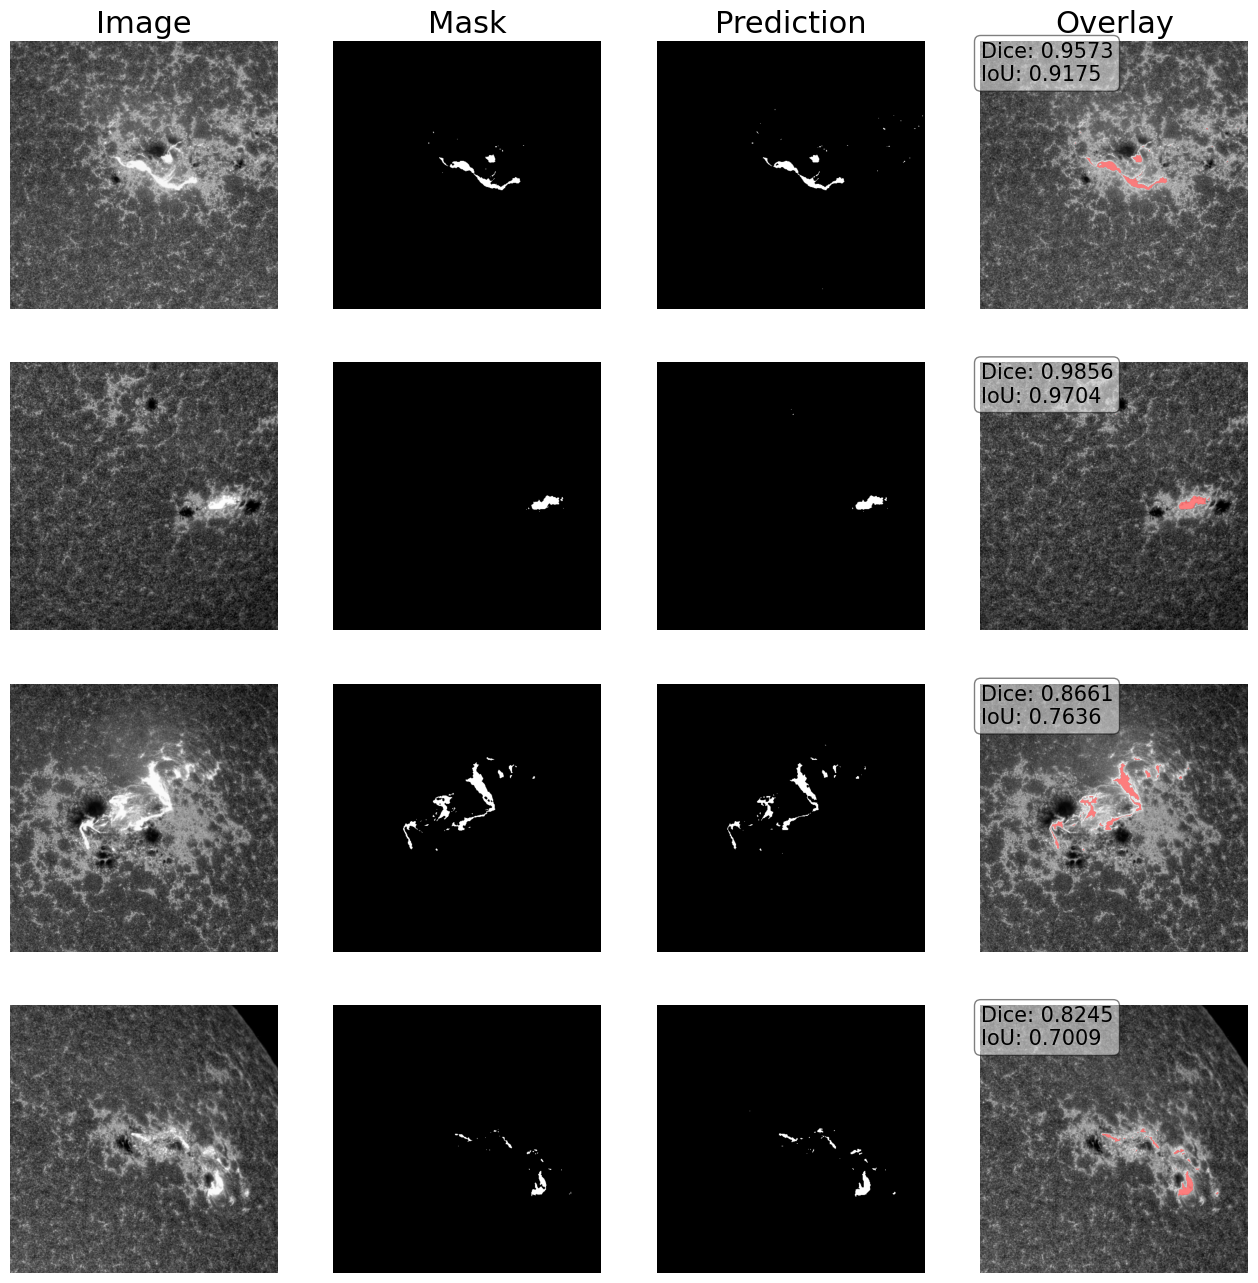

In [28]:
n = 103
plot_imgs(imgs=x_test[n:], masks =y_test[n:], predictions=y_pred[n:]>0.6, n_imgs=4)

### Calculate metrics with and without treshold

In [23]:
y_pred_bin = np.where(y_pred>0.6, 1, 0)  # Binarize predicted values

dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

print(f"Test:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

Test:
Dice: 0.8764 Dice_tresh: 0.9269
 IoU: 0.7801 IoU_tresh: 0.8638



## 4. DETECTING PARALLEL FLARE RIBBONS

In [32]:
# create list for storing images that have parallel lines
parallel_list = []

predictions = y_pred

for image in range(len(predictions)):
    # check for images that have too much noise
    if np.count_nonzero(predictions[image] >= 0.6) < 1200:
        continue
    # correct img shape for pruning
    img = np.squeeze(predictions[image])
    
    # use 3D skeletonization on the mask
    skeleton = skeletonize_3d(img)
    
    # get distances from skeleton
    dist = distance_transform_edt(skeleton, return_indices=False, return_distances=True)
    
    # if there are just very small regions in the image
    if np.count_nonzero(dist >= 1) < 200:
        continue

    # create pruned skeleton by removing small branches
    pruned_skeleton = skel_pruning_DSE(skeleton, dist, 40)
  
    pruned_skeleton = np.uint8(pruned_skeleton * 255)
   
    # apply probabilistic Hough transform
    lines = cv2.HoughLinesP(pruned_skeleton, 1, np.pi/180, 5, minLineLength=8, maxLineGap=10)
    
    # in case there are len than two or too many lines found, skip it
    if lines is None or len(lines) < 2:
        continue
   
    # clean found lines
    lines_cleaned = cleanLines(lines)
    
    parallel_lines = []
    
    for i in range(len(lines_cleaned)):
        x1, y1, x2, y2 = lines_cleaned[i][0]

        length = getLength(x1, y1, x2, y2)
        # skip too short lines
        if length < 25:
            continue

        slope = getSlope(x1, y1, x2, y2)

        for j in range(i+1, len(lines_cleaned)):
            x3, y3, x4, y4 = lines_cleaned[j][0]
            
            length2 = getLength(x3, y3, x4, y4)
            # skip too short lines
            if length2 < 25:
                continue
            
            # skip lines that are intersecting
            if intersects(x1, y1, x2, y2, x3, y3, x4, y4):
                continue

            slope2 = getSlope(x3, y3, x4, y4)
            
            # check if the lines are above themselves or next to each other
            if (y1 > max(y3,y4) and y2 > max(y3, y4)) or (y3 > max(y1, y2) and y4 > max(y1, y2)):
                if (x1 > max(x3,x4) and x2 > max(x3, x4)) or (x3 > max(x1, x2) and x4 > max(x1, x2)):
                    continue
                                
            #calculate shortest distance between the two lines
            shortest_distance = min(minDistance(x1,y1,x2,y2,x3,y3), minDistance(x1,y1,x2,y2,x4,y4),minDistance(x3,y3,x4,y4,x1,y1),minDistance(x3,y3,x4,y4,x2,y2))
            
            # if lines have small slope difference, same slope signs and distance within the two values, consider them parallel
            if abs(slope - slope2) < 0.5  and (slope > 0 and slope2 > 0 or slope < 0 and slope2 < 0) and (shortest_distance > 20 and shortest_distance < 100):
                parallel_lines.append([lines_cleaned[i], lines_cleaned[j]])
                
    # if no parallel lines were found in the image, continue with the next one
    if len(parallel_lines) == 0:
        continue
    # otherwise add the image to the list containing parallel flare ribbons
    else:
        print(x_test_names[image], image, "paralelne: ", len(parallel_lines))
        parallel_list.append(x_test[image])
        
        
        
print(len(parallel_list))

2013-12-31_21-52-16_AIA1600.jp2 46 paralelne:  1
2014-10-24_21-38-40_AIA1600.jp2 105 paralelne:  2
2012-07-06_02-49-05_AIA1600.jp2 106 paralelne:  1
2014-11-07_17-26-40_AIA1600.jp2 181 paralelne:  1
2012-03-10_17-24-17_AIA1600.jp2 282 paralelne:  1
2013-12-31_22-04-16_AIA1600.jp2 474 paralelne:  1
2012-03-07_01-08-41_AIA1600.jp2 524 paralelne:  1
2014-10-24_21-15-52_AIA1600.jp2 853 paralelne:  1
2012-03-10_17-26-41_AIA1600.jp2 978 paralelne:  1
9


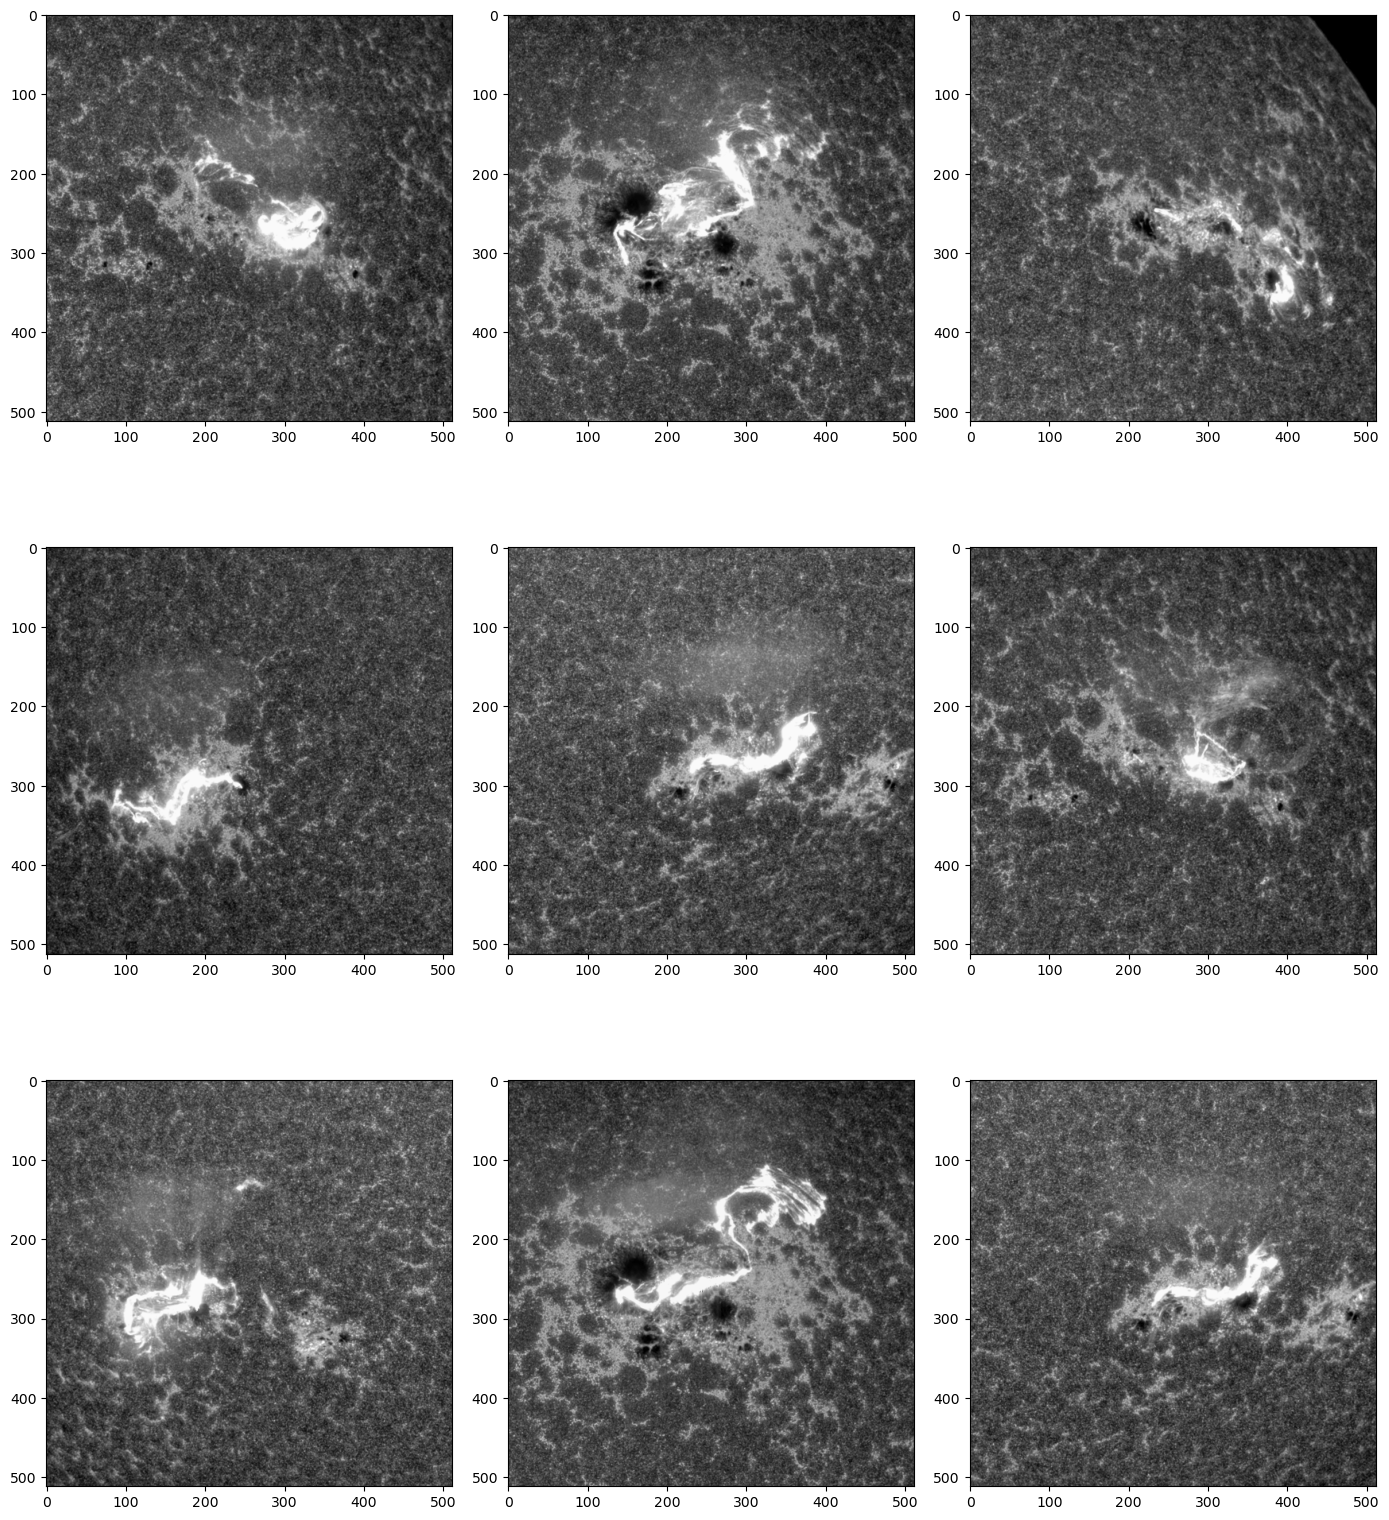

In [39]:
# display detected events
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [14, len(parallel_list)*2]
fig = plt.figure()
for i,j in enumerate(parallel_list):
    plt.subplot(math.ceil(len(parallel_list)/3), 3, i+1)
    plt.imshow(parallel_list[i], cmap="gray")